Реализовать синтезирование лиц из LFW с помощью DCGAN

Библиотеки: [Python, Tensorflow]

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

import warnings
warnings.filterwarnings("ignore")

with warnings.catch_warnings():
    pass

import logging

logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
print(tf.__version__)

2.1.0


In [4]:
train_ds, ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split='train',
)

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

In [6]:
train_ds

<PrefetchDataset shapes: ((), (250, 250, 3)), types: (tf.string, tf.uint8)>

In [7]:
some_samples = [some_images for some_labels, some_images in iter(train_ds.take(32))]

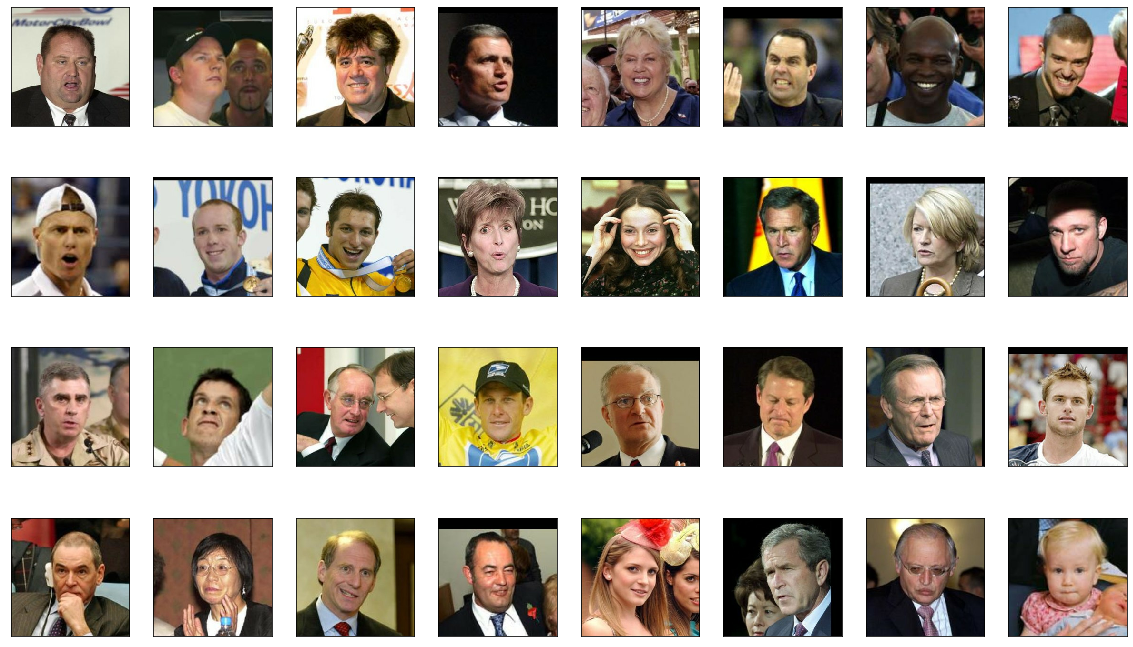

In [8]:
def plot_samples(images):
  fig = plt.figure(figsize=(20, 12))
  for j in range(len(images)):
      ax = fig.add_subplot(4, 8, j+1)
      ax.imshow(images[j])
      plt.xticks([]), plt.yticks([])
  plt.show()

plot_samples(some_samples) 

In [9]:
def prepare(label, img):
    img = tf.image.resize(img, [224, 224])
    return label, (tf.cast(img, tf.float32)- 127.5) / 127.5

In [10]:
INPUT_DIM = 100
NUM_EPOCHS = 10
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002

In [11]:
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

In [12]:
train_ds

<BatchDataset shapes: ((16,), (16, 224, 224, 3)), types: (tf.string, tf.float32)>

In [13]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256*7*7, activation='relu'),
    tf.keras.layers.Reshape((7, 7, 256)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),  
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),  
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(), 
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(16, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),
])


discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

In [14]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

[Step  0] D Loss: 1.3016; G Loss: 0.5760


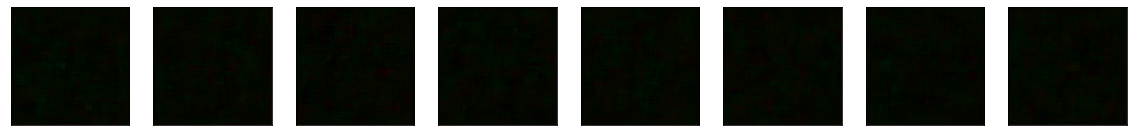

[Step 200] D Loss: 1.0271; G Loss: 0.0887


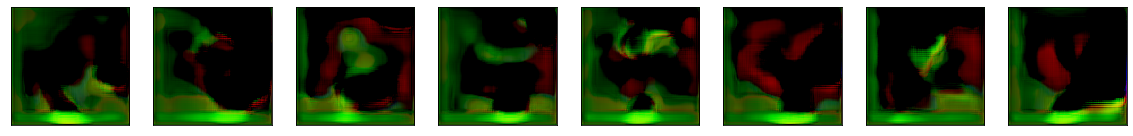

[Step 400] D Loss: 3.3331; G Loss: 5.4651


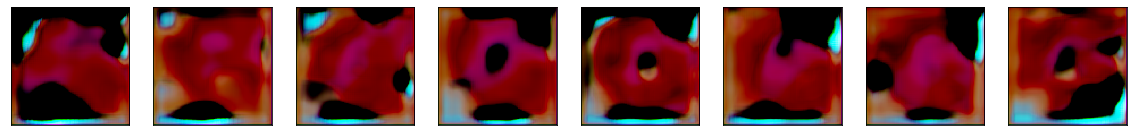

[Step 600] D Loss: 7.8434; G Loss: 14.5244


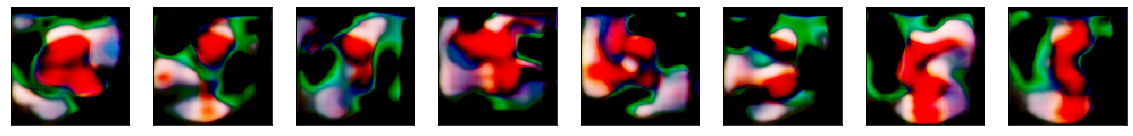

[Step 800] D Loss: 9.6979; G Loss: 13.5368


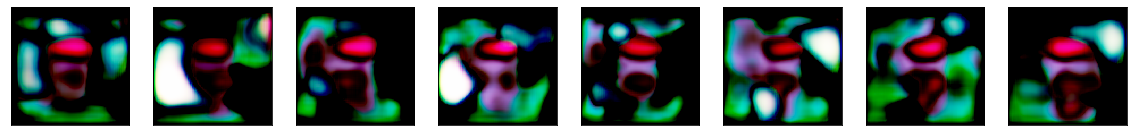

[Step 1000] D Loss: 4.4491; G Loss: 19.9887


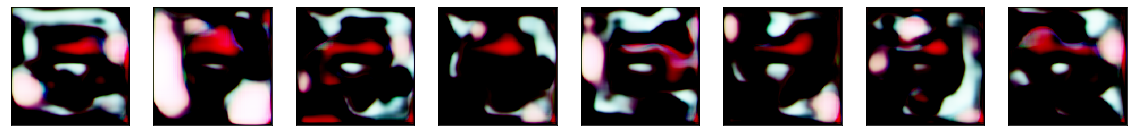

[Step 1200] D Loss: 3.4767; G Loss: 77.6873


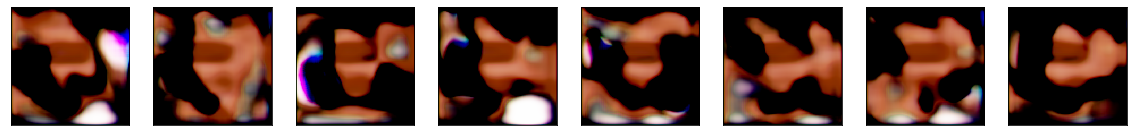

[Step 1400] D Loss: 2.8527; G Loss: 13.3504


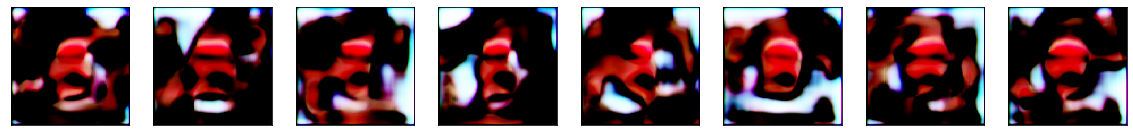

[Step 1600] D Loss: 0.9318; G Loss: 51.8425


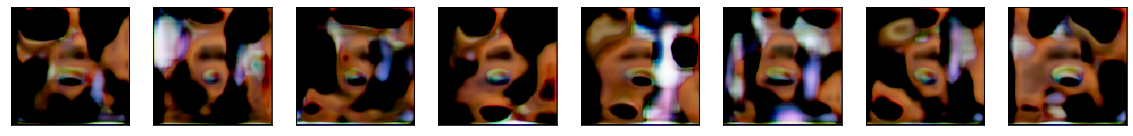

[Step 1800] D Loss: 1.6466; G Loss: 17.7826


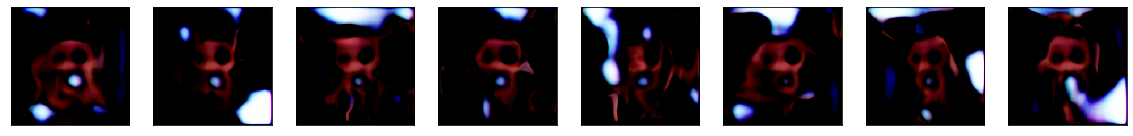

[Step 2000] D Loss: 2.4000; G Loss: 27.0768


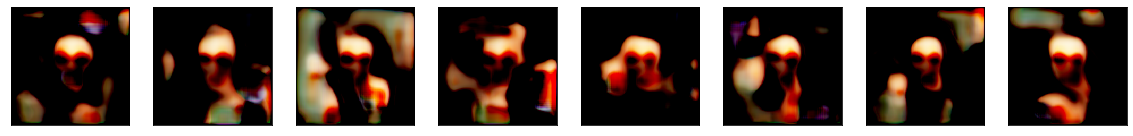

[Step 2200] D Loss: 0.0000; G Loss: 28.7927


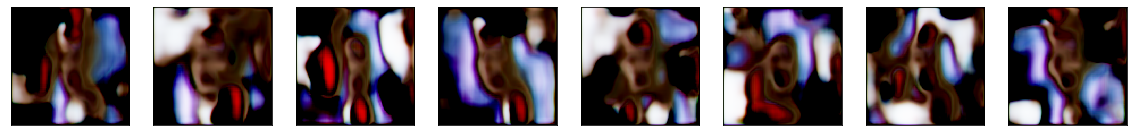

[Step 2400] D Loss: 1.1870; G Loss: 17.6956


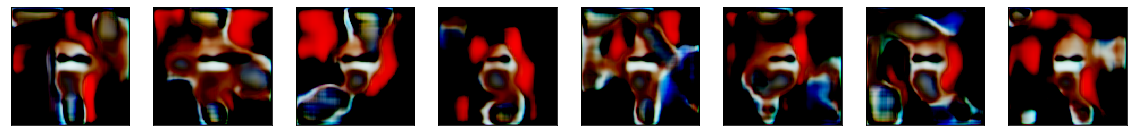

[Step 2600] D Loss: 1.3475; G Loss: 6.1646


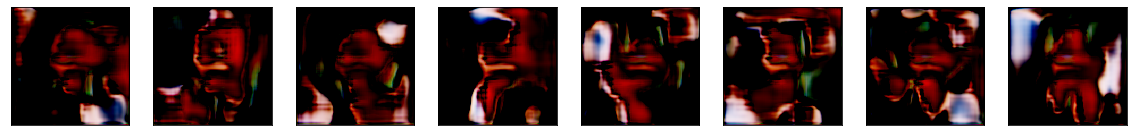

[Step 2800] D Loss: 4.6408; G Loss: 12.3813


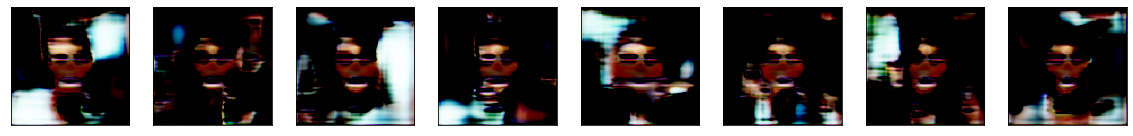

[Step 3000] D Loss: 1.8454; G Loss: 17.2945


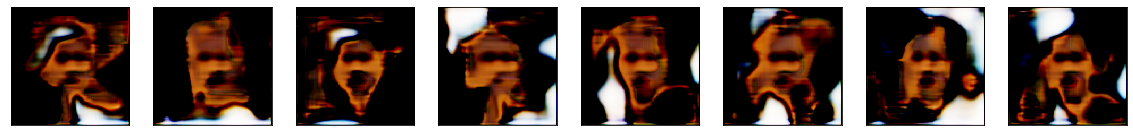

[Step 3200] D Loss: 0.0153; G Loss: 70.8624


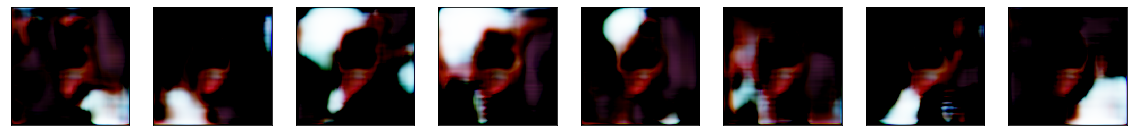

[Step 3400] D Loss: 0.4455; G Loss: 9.6245


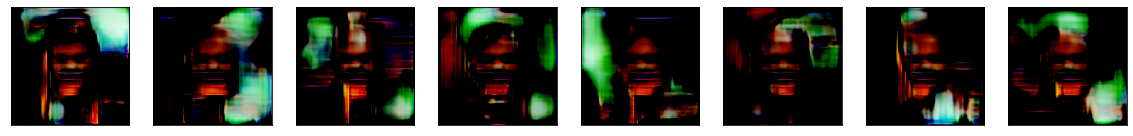

[Step 3600] D Loss: 1.6199; G Loss: 14.3794


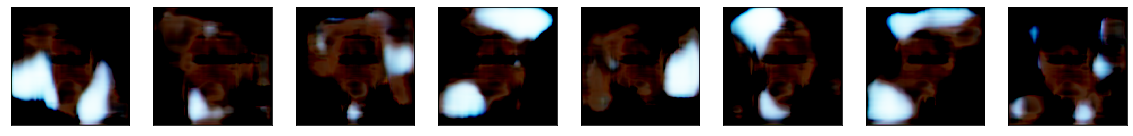

[Step 3800] D Loss: 0.9013; G Loss: 8.0214


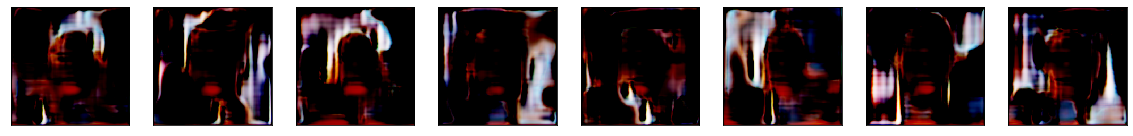

[Step 4000] D Loss: 7.0916; G Loss: 7.7234


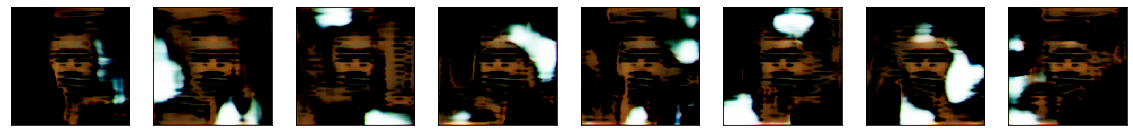

[Step 4200] D Loss: 1.6380; G Loss: 2.1382


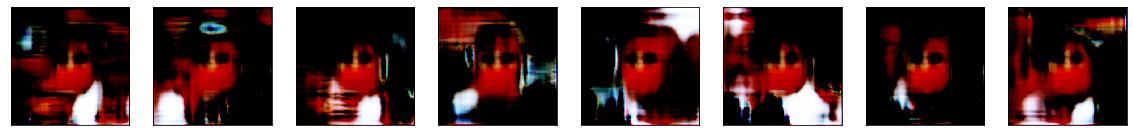

[Step 4400] D Loss: 1.4232; G Loss: 17.6611


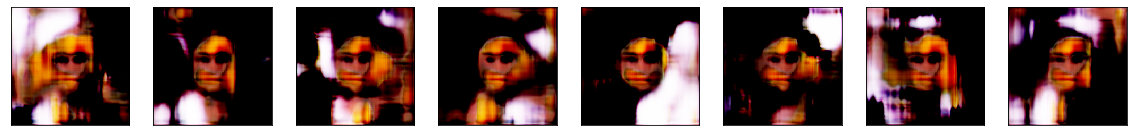

[Step 4600] D Loss: 3.4018; G Loss: 10.8730


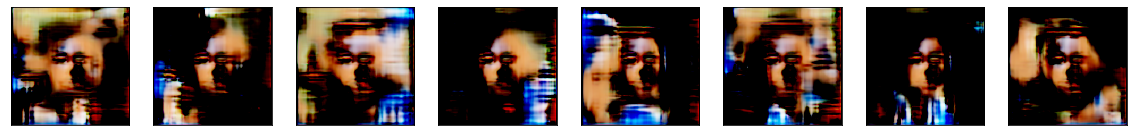

[Step 4800] D Loss: 0.0256; G Loss: 41.5526


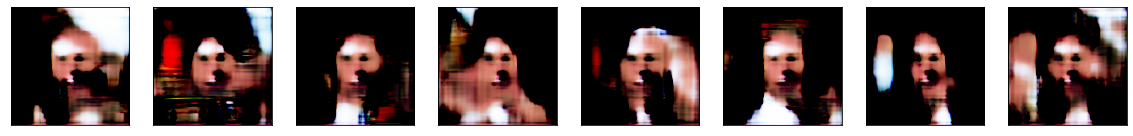

[Step 5000] D Loss: 1.3501; G Loss: 7.8021


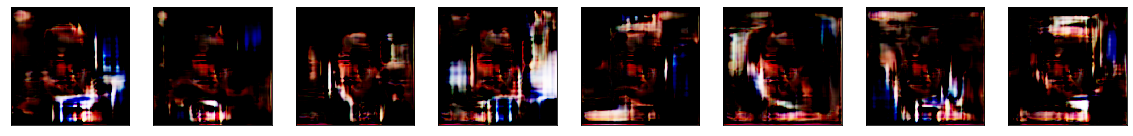

[Step 5200] D Loss: 4.5870; G Loss: 21.3395


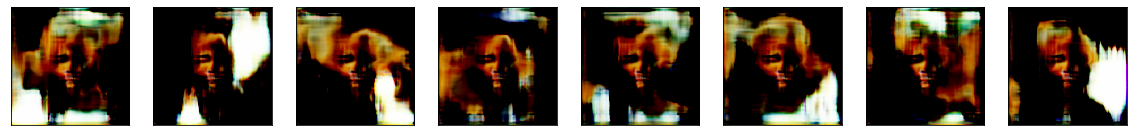

[Step 5400] D Loss: 0.2389; G Loss: 9.8993


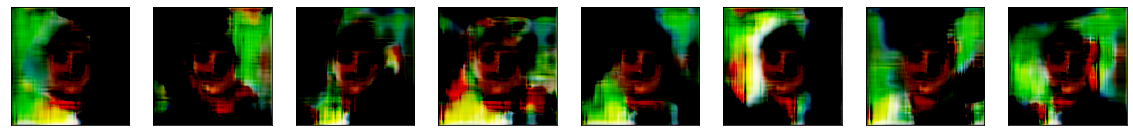

[Step 5600] D Loss: 2.0639; G Loss: 29.9844


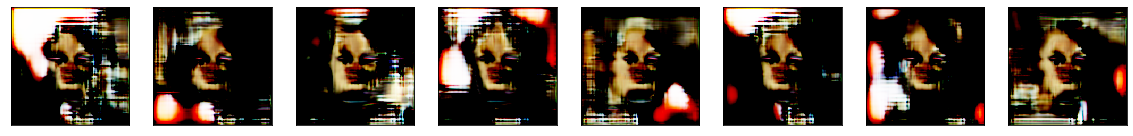

[Step 5800] D Loss: 0.2114; G Loss: 21.3580


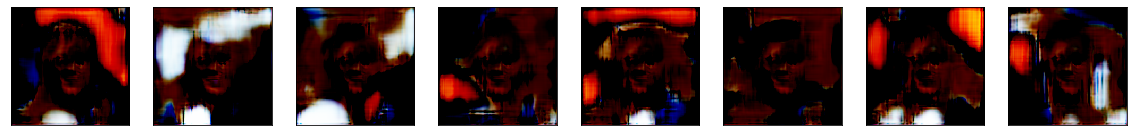

[Step 6000] D Loss: 1.3881; G Loss: 18.2338


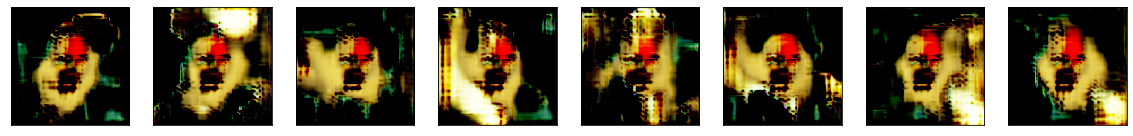

[Step 6200] D Loss: 0.4010; G Loss: 13.7407


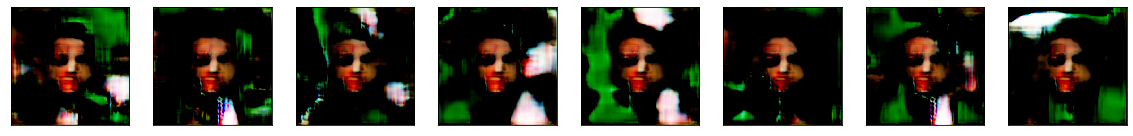

[Step 6400] D Loss: 0.6121; G Loss: 1.9598


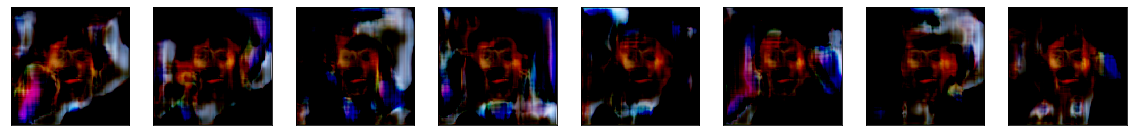

[Step 6600] D Loss: 1.8780; G Loss: 29.8117


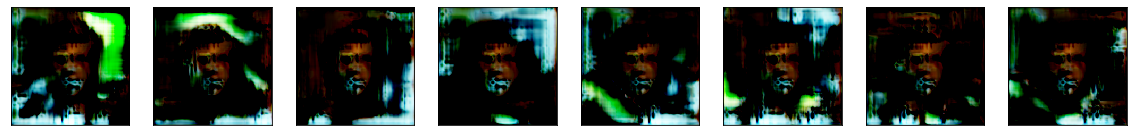

[Step 6800] D Loss: 2.0467; G Loss: 16.6875


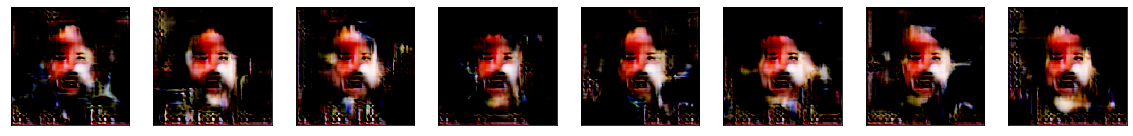

[Step 7000] D Loss: 0.0007; G Loss: 9.8143


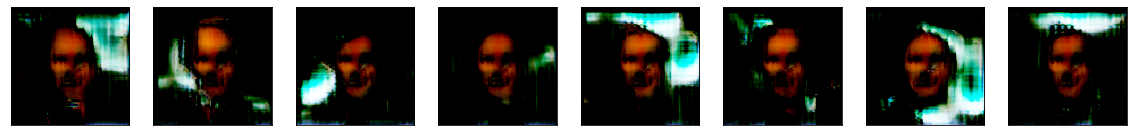

[Step 7200] D Loss: 1.1350; G Loss: 13.5373


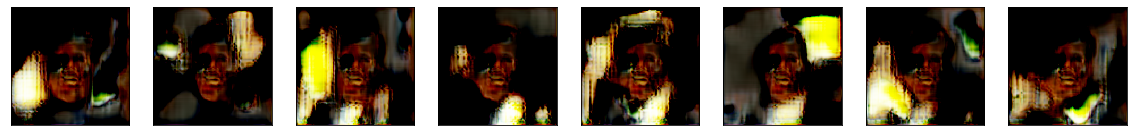

[Step 7400] D Loss: 2.7604; G Loss: 30.2499


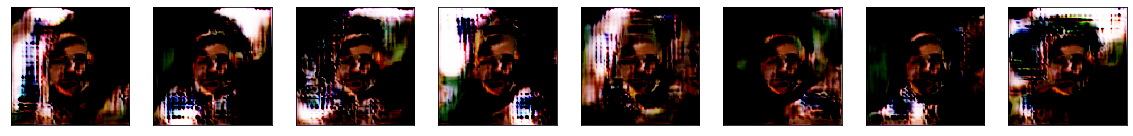

[Step 7600] D Loss: 1.0688; G Loss: 13.6688


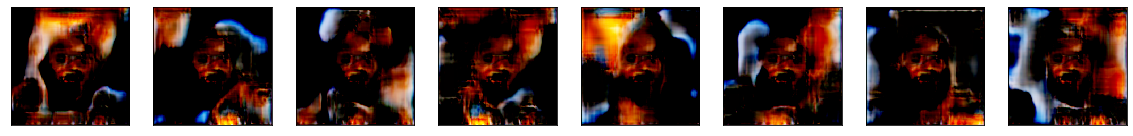

[Step 7800] D Loss: 1.7729; G Loss: 8.8210


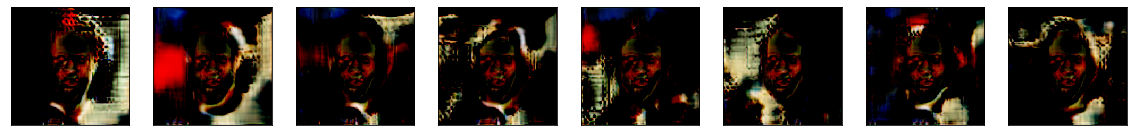

[Step 8000] D Loss: 4.5055; G Loss: 17.9015


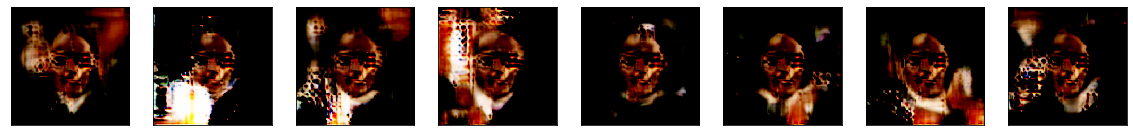

[Step 8200] D Loss: 1.1065; G Loss: 18.4730


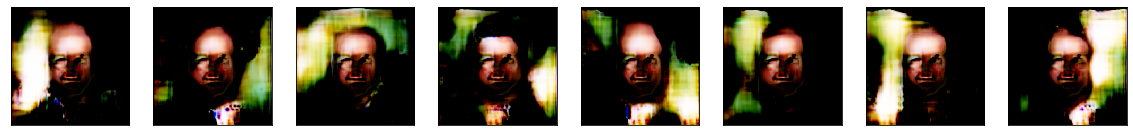

In [15]:
for step, (_, true_images) in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 200 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_samples(syntetic_images)


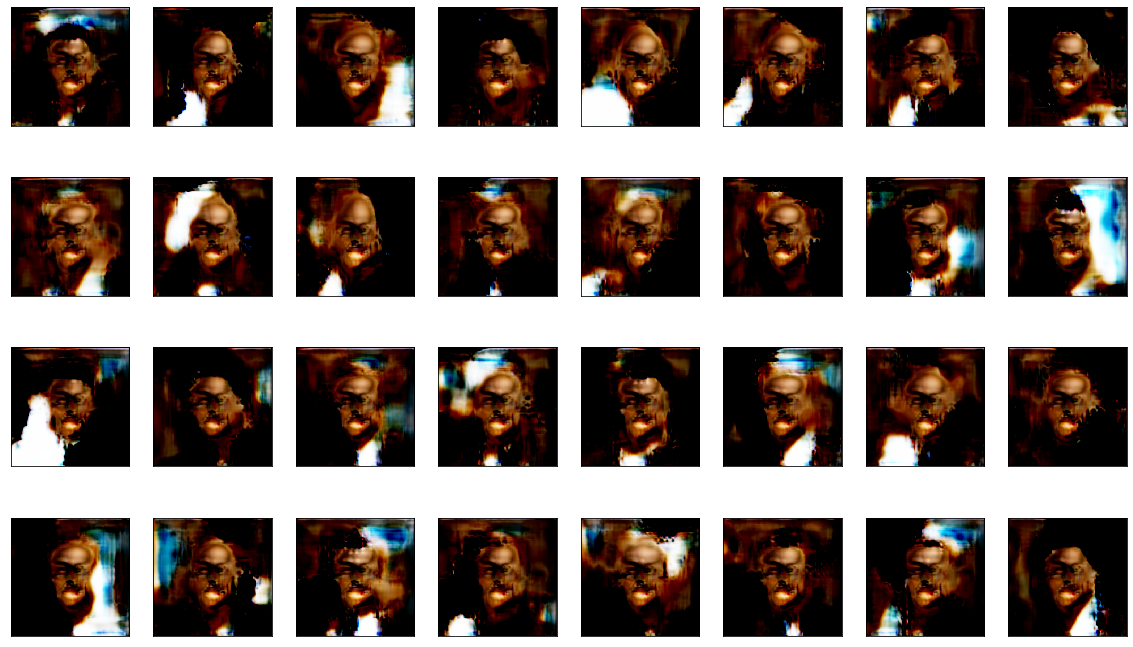

In [17]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_samples(syntetic_images)

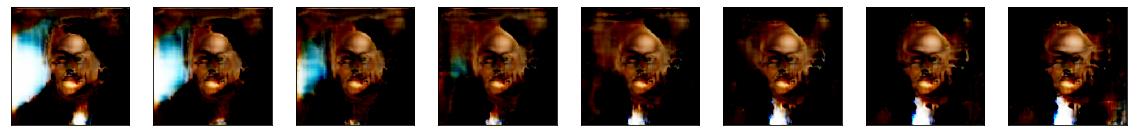

In [19]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_samples(syntetic_images)

Лица похожи больше на кадры из фильма ужасов, но общие очертания лица уже есть, наверное, нужно больше эпох для обучения или побольше сетка

In [20]:
generator.save('generator.h5')

In [21]:
discriminator.save('discriminator.h5')